<a href="https://colab.research.google.com/github/borglab/gtsam.org/blob/master/notebooks/Laplacian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Rainier's Factor Graph and Eigenvectors

### [Frank Dellaert](https://dellaert.github.io), August 30, 2020

In this post I'll talk a bit about estimating absolute quantities from relative measurements, using the reconstruction of [Mount Rainier](https://en.wikipedia.org/wiki/Mount_Rainier) as a motivating example. I'll show how the Hessian of that problem is exactly the "Graph Laplacian" from graph theory, and relate the eigen-decomposition of that graph with the properties of the reconstruction.

There is an accompaning [Youtube video](https://www.youtube.com/watch?v=-U00XjFLQag).

In [1]:
#@Libraries we need
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import image
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import numpy as np
import scipy
from sklearn.neighbors import NearestNeighbors

## Reconstructing Mount Rainier
Imagine you and your friends have climbed Mount Rainier, and you were able to obtain a large number of *relative* height measurements: can we reconstruct the shape of the mountain from those? It turns out the answer is yes, modulo an unknown height offset.

To simulate this scenario, I will use a [Digital Elevation Model (DEM)](https://en.wikipedia.org/wiki/Digital_elevation_model). It's not super-easy to get one's hands on digital elevation data, but luckily [Matt Booty has done it for us](https://mattbooty.wordpress.com/2019/01/20/3d-printing-a-model-of-mount-rainier-using-digital-elevation-model-dem-files/) for Mount Rainier. Below we download the image and load it into this notebook.


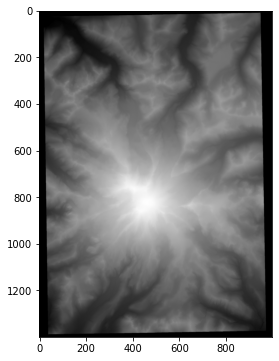

In [2]:
!wget -q https://mattbooty.files.wordpress.com/2019/01/mr-dem-height-map-output-03.jpg
dem = image.imread('mr-dem-height-map-output-03.jpg')
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(dem);

First, we'll get some sample points, corresponding to where you and your friends would have taken measurements. In this example we assume we know the 2D locations of the points, although it is not hard to extend the example beyond that assumption.

The code below samples 500 different locations and shows them on the DEM:

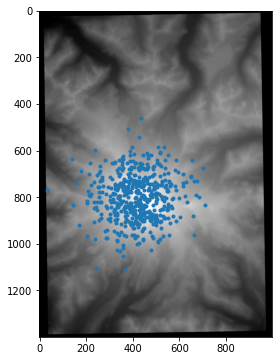

In [3]:
coordinates = np.random.multivariate_normal(mean=[420,800], cov=100*100*np.eye(2),size=500)
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(dem);
ax.scatter(coordinates[:,0], coordinates[:,1], marker='.')
plt.show()

Let's collect all 2D and their associated ground-truth heights into a numpy array, filtering out samples from the black border.

In [4]:
truth = np.array([(x,y,dem[y,x,0]) for x,y in np.round(coordinates).astype(np.int) if dem[y,x,0]>0])
N = truth.shape[0]
z = truth[:,2]

To create relative measurements, we'll use a graph derived from the K-nearest neighbors. 

The associated estimation problem is to minimize a sum of linear least-squares terms $\|z_j -z_i - \delta_{ij}\|^2$. 
In GTSAM each of these terms corresponds to a pairwise JacobianFactor, and in this linear case, the resulting factor graph is completely equivalent to a sparse rectangular matrix $H$, with entries 1 and -1.

From the graph $G$ we can easily generate this sparse measurement matrix $H$ using the `incidence_matrix` function in `networkx`. The relative measurements $d$ are then obtained as $d=H z$ where $z$ are the ground truth height values.

In [5]:
# Find nearest Neighbors
neigh = NearestNeighbors(n_neighbors=6, radius=100)
neigh.fit(truth)
A = neigh.kneighbors_graph()

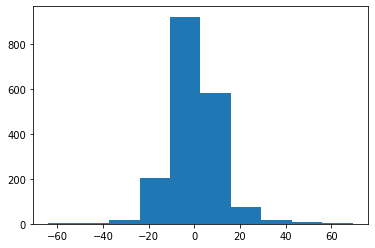

In [6]:
# Create graph
G0 = nx.from_scipy_sparse_matrix(A)

# Create measurement matrix H
H = nx.incidence_matrix(G0, oriented=True).transpose()
M, N = H.shape

# Simulate measurements d
d = H @ z + np.random.normal(size=(M,),scale=1)
plt.hist(d);

Unfortunately relative measurements alone can never tell us about absolute height. To remedy this we add one row to $H$ to clamp $\hat{z}[0]$ to $100$, and we then use the `lsqr` method in scipy to obtain estimated heights $\hat{z}$:


In [7]:
H1 = scipy.sparse.bmat([[H], [scipy.sparse.eye(1,N)]])
d1 = np.concatenate((d,[truth[0,2]]))
z, istop, itn, r1norm = scipy.sparse.linalg.lsqr(H1, d1)[:4]

Finally, let's render the result in 3D:

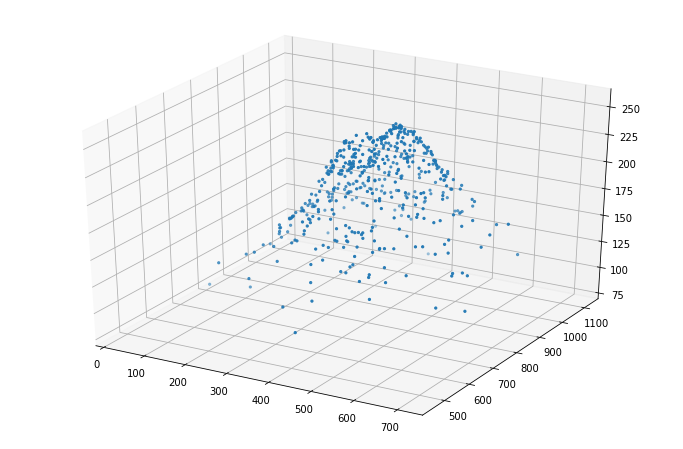

In [8]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(truth[:,0], truth[:,1], z, marker='.');

That does not look half-bad ;-)

## Of Jacobians, Hessians, and Graph Laplacians 

The large (but sparse) measurement matrix $H$ we used above is also called the **Jacobian**, and the `lsqr` method solved the linear least-squares problem $\hat{z} = \arg\min_z \|H z - d \|^2$. This is really just a multivariate quadratic with its curvature given by the **Hessian** $Q\doteq H^TH$. The Hessian is also known as the **information matrix**, and is equal to the inverse of the **covariance matrix** $P\doteq Q^{-1}$.

The significance of all this that the Hessian $Q$ tells us exactly *how much we know* about the estimated heights given the measurements and the uncertainty associated with the measurements (which here we silently assumed to be zero-mean Gaussian additive noise with unit standard deviation $\sigma=1$).

To explore this in a bit more depth, let's simplify the problem even more and only consider 1D mountains. Below we walk up a mountain and record  relative height measurements between 6 subsequent points: 

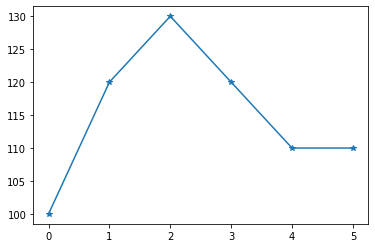

In [9]:
z = np.array([100,120,130,120,110,110])
plt.plot(z,'-*');

Let us take measurements both between neighboring points as well as points one hop away, which should intuitively improve our estimates:

In [10]:
G = nx.Graph()
G.add_edges_from([(0,1),(0,2),(1,2),(1,3),(2,3),(2,4),(3,4),(3,5),(4,5)])
H = nx.incidence_matrix(G, oriented=True).transpose()
M, N = H.shape
d = H @ z + np.random.normal(size=(M,),scale=1)

If we calculate at the Hessian $Q=H^T H$ for this simpler problem, we see that it is a $6\times 6$ matrix:

In [11]:
Q = H.T@ H
print(Q.toarray().astype(np.int))

[[ 2 -1 -1  0  0  0]
 [-1  3 -1 -1  0  0]
 [-1 -1  4 -1 -1  0]
 [ 0 -1 -1  4 -1 -1]
 [ 0  0 -1 -1  3 -1]
 [ 0  0  0 -1 -1  2]]


Graph theory also defines the [Laplacian Matrix](https://en.wikipedia.org/wiki/Laplacian_matrix) $L=D-A$ of an undirected graph $G$, where $D$ is a diagonal degree matrix and $A$ is the adjacency matrix of the graph.

The Laplacian $L$ associated with this matrix is easy to calculate, but we'll use `networkx` to do it for us:

In [12]:
L = nx.linalg.laplacian_matrix(G).toarray()
print(L)

[[ 2 -1 -1  0  0  0]
 [-1  3 -1 -1  0  0]
 [-1 -1  4 -1 -1  0]
 [ 0 -1 -1  4 -1 -1]
 [ 0  0 -1 -1  3 -1]
 [ 0  0  0 -1 -1  2]]


As we can see, **for this problem the Hessian and the Graph Laplacian are identical**.

This nicely connects estimation and graph theory. In particular, in graph theory the eigenvalues and eigenvectors of the graph Laplacian $L$ are of particular interest, and we will be able to connect them to the SVD of the measurement matrix $H$ and by extension $Q$.

In the above, by using entries $-1$ and $1$ in the measurement matrix $H$, we implicitly asssumed unit variance. In general each row (and corresponding RHS element) can be scaled differently to account for different measurement noise, in which case we need to work with a *weighted* Laplacian. However, for simplicity we assume unit variance below.

First, let us calculate the eigen-decomposition of $L$. We will use the [singular value decomposition or SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition) to do this as that nicely sorts the eigenvalues for us in decreasing magnitude order:

In [13]:
eigenvectors, eigenvalues, _ = np.linalg.svd(L)
print(np.round(eigenvalues,2))
print(np.round(eigenvectors,2))

[5.34 5.   3.47 3.   1.19 0.  ]
[[ 0.23  0.   -0.29  0.58  0.6   0.41]
 [-0.1  -0.5   0.62 -0.29  0.33  0.41]
 [-0.66  0.5  -0.19 -0.29  0.16  0.41]
 [ 0.66  0.5   0.19 -0.29 -0.16  0.41]
 [ 0.1  -0.5  -0.62 -0.29 -0.33  0.41]
 [-0.23  0.    0.29  0.58 -0.6   0.41]]


However, because we have $L=Q=H^TH$, we can *also* do obtain this by taking the SVD of $H$:

In [14]:
_, S, V = np.linalg.svd(H.toarray())
print(np.round(S**2,2)) # square to get eigenvalues of Q!
print(np.round(V.transpose(),2))

[5.34 5.   3.47 3.   1.19 0.  ]
[[ 0.23 -0.   -0.29  0.58  0.6  -0.41]
 [-0.1  -0.5   0.62 -0.29  0.33 -0.41]
 [-0.66  0.5  -0.19 -0.29  0.16 -0.41]
 [ 0.66  0.5   0.19 -0.29 -0.16 -0.41]
 [ 0.1  -0.5  -0.62 -0.29 -0.33 -0.41]
 [-0.23 -0.    0.29  0.58 -0.6  -0.41]]


Based on this, we can start to understand some properties that are often discussed in the context of the graph Laplacian:

**1. The smallest eigenvalue of $L$ is zero, and the associated eigenvector is all ones, up to a scale.**

In [15]:
print("Eigenvalues=\n  {}".format(np.round(eigenvalues,2)), 
      "\nEigenvector associated with first zero=\n  {}".format(np.round(eigenvectors[:,-1],2))
      )

Eigenvalues=
  [5.34 5.   3.47 3.   1.19 0.  ] 
Eigenvector associated with first zero=
  [0.41 0.41 0.41 0.41 0.41 0.41]


Let's unpack this: if we interpret the graph Laplacian $L$ as an the information matrix $Q$ the result above says that there is a direction in the space of unknowns in which we have *zero information*. This makes total sense: since we only have *relative* measurements, we can add a constant without changing the objective function: that corresponds to the first eigenvector.

**2. If the graph $G$ is disconnected, the second eigenvalue is also zero.**

We can examine this by looking at two mountaintops, by just replicating H:

In [16]:
H2 = np.zeros((2*M,2*N))
H2[:M,:N]=H.toarray()
H2[M:,N:]=H.toarray()
Q2 = H2.T @ H2
eigenvectors2, eigenvalues2, _ = np.linalg.svd(Q2)
print("Eigenvalues=\n  {}".format(np.round(eigenvalues2)), 
      "\nEigenvector associated with first zero=\n  {}".format(np.round(eigenvectors2[:,-1],2)),
      "\nEigenvector associated with second zero=\n  {}".format(np.round(eigenvectors2[:,-2],2))
      )

Eigenvalues=
  [5. 5. 5. 5. 3. 3. 3. 3. 1. 1. 0. 0.] 
Eigenvector associated with first zero=
  [-0.   -0.   -0.   -0.   -0.   -0.    0.41  0.41  0.41  0.41  0.41  0.41] 
Eigenvector associated with second zero=
  [ 0.41  0.41  0.41  0.41  0.41  0.41 -0.    0.    0.    0.    0.    0.  ]


This is also not surprising: even though this simulates scaling the two mountain tops and recording our elevation changes, we have no measurements connecting the two mountains, and hence we can *indepedently* vary the height of iether mountain, without violating any measurement constraint. That corresponds to the two eigenvectors associated with the two zero eigenvalues.

This is also the basis for [spectral partitioning/clustering methods](https://en.wikipedia.org/wiki/Spectral_clustering): the eigenvectors neatly separate the graph into two components, and this can be generalized to more sophisticated clustering methods.

This is even better appreciated by plotting both eigenvectors:

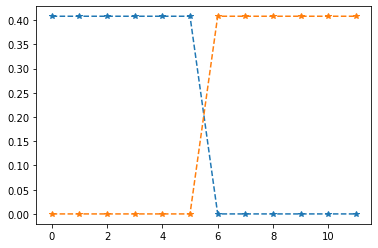

In [17]:
fig=plt.plot(eigenvectors2[:,-2:],'--*')


**3. The second-smallest eigenvalue, called the [Algebraic Connectivity or Fiedler value](https://en.wikipedia.org/wiki/Algebraic_connectivity) is greater than zero if the graph is connected, and measures the global connectivity in the graph.**

In our original 6-node mountain top problem, the Fiedler value is approximatey 1.19:

In [18]:
print("lambda = {}".format(round(eigenvalues[-2],2)))
print("with networkx: {}".format(round(nx.algebraic_connectivity(G),2)))

lambda = 1.19
with networkx: 1.19


**4. The eigenvector associated with the Fiedler value, also called the "Fiedler vector", is the direction in space that incurs the least error in the scalar synchronization problem.**

Per the spectral clustering idea, it can also be used to partition the graph into two parts, even if the graph is not disconnected. This can be appreciated by plotting the Fiedler vector for the original mountain top:

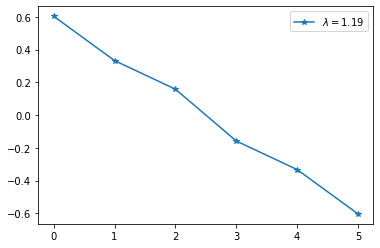

In [19]:
fig=plt.plot(eigenvectors[:,-2], '-*')
plt.legend(["$\lambda = {}$".format(round(eigenvalues[-2],2))],loc='upper right');

Just by thresholding on zero we can neatly partition the mountain in the left half, and the right half!


**5. The remaining eigenvectors of $L$ (or $Q$) are increasingly "high frequency" modes that identify directions in space that incur high costs.**

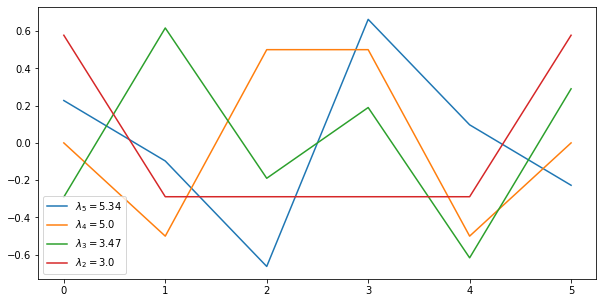

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(eigenvectors[:,:-2])
plt.legend(["$\lambda_{} = {}$".format(5-i, round(e,2)) for i,e in enumerate(eigenvalues[:-2])],loc='lower left');

For example, the blue "mode" associated with $\lambda_5$ shows that modifying the values of neighboring nodes 2 and 3 in opposite ways will be quite expensive.

The SVD is a generalization of the Fourier transform, in that the SVD of the Laplacian of a ring *will* in fact yield the DFT:

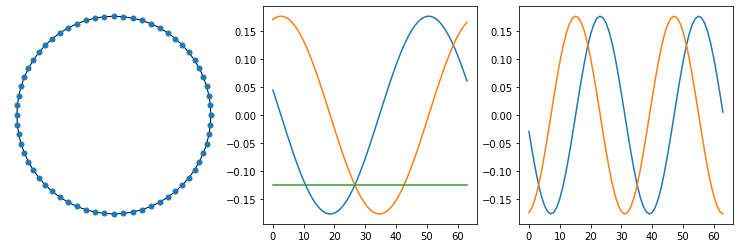

In [21]:
G3 = nx.watts_strogatz_graph(64, 2, 0) # ring is simply special case of WS graph
fig, ax = plt.subplots(ncols=3,figsize=(13, 4))
nx.draw_circular(G3, node_size=25, ax=ax[0])
L3 = nx.linalg.laplacian_matrix(G3).toarray()
eigenvectors3, eigenvalues3, _ = np.linalg.svd(L3)
ax[1].plot(eigenvectors3[:,-3:]);
ax[2].plot(eigenvectors3[:,-5:-3]);

Just to close the thread, as we saw before in the Mount Rainier example, if we have an absolute measurement then we can simply add a "prior" to our factor graph $H$ and RHS $d$, and we will get a definite answer:

In [22]:
H1 = np.concatenate((H.toarray(), [[1,0,0,0,0,0]]), axis=0)
d1 = np.concatenate((d,[100]))
Q1 = H1.T @ H1
z = np.linalg.inv(Q1) @ H1.T @ d1
print(z)

[100.         120.58209315 130.93187894 121.5545199  111.91568719
 112.93594435]


Because there is no contradictory information regarding the value of $z_0$, the solution adopts that prior exactly.

It is instructive to abandon the "pure Laplacian" view here and look at the eigenvalues and eigenvectors of the Hessian of this new problem, which is no longer indeterminate:

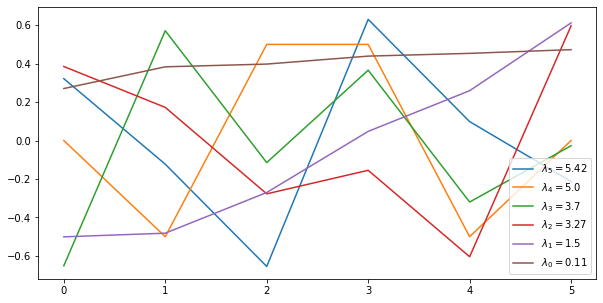

In [23]:
eigenvectors, eigenvalues, _ = np.linalg.svd(Q1)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(eigenvectors)
ax.legend(["$\lambda_{} = {}$".format(5-i, round(e,2)) for i,e in enumerate(eigenvalues)],loc='lower right');

As you can see:

1. the smallest eigenvalue is no longer zero: we now incur a definite cost of moving up and down, but the eigenvector associated with $\lambda_1$ suggests that it this is less so for nodes far away from the "anchor node".
2. The eigenvectors associated with $\lambda_5$ has a zero in the front and its eigenvalue is the same as before.
3. The remaining eigenvectors have larger eigenvalues as they also change the anchor node, which now has higher cost.



## Mount Rainier's Eigenvectors


We will use the sparse/fast methods from networkx to calculate the Fiedler value and Fiedler vector:

0.05266912301429308


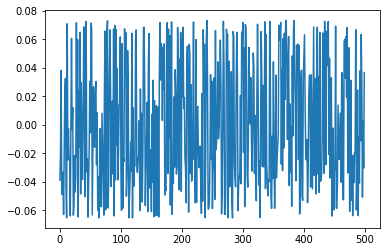

In [24]:
fiedler_value = nx.algebraic_connectivity(G0)
print(fiedler_value)
fiedler_vector = nx.fiedler_vector(G0)
plt.plot(fiedler_vector);

It does not look very good in 1D, so let's plot it in 3D, using a colormap to encode the Fiedler vector's values:

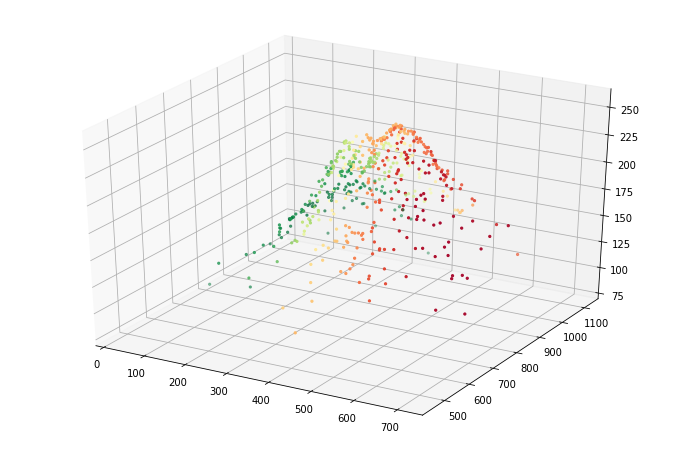

In [25]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
z = truth[:,2]
ax.scatter(truth[:,0], truth[:,1], z, marker='.', c=fiedler_vector,cmap='RdYlGn');

It is even clearer from the top: below we plot an overhead view, in which we can clearly see that the two "halves" of Mount Rainier can move more or less independently without incurring much error. Hence, this is the lowest frequency mode over which we do have some information (but not much).

If you are running the notebook, you could try playing with the number of neighbors in the KNN calculation, and see how the Fiedler vector changes as a result.

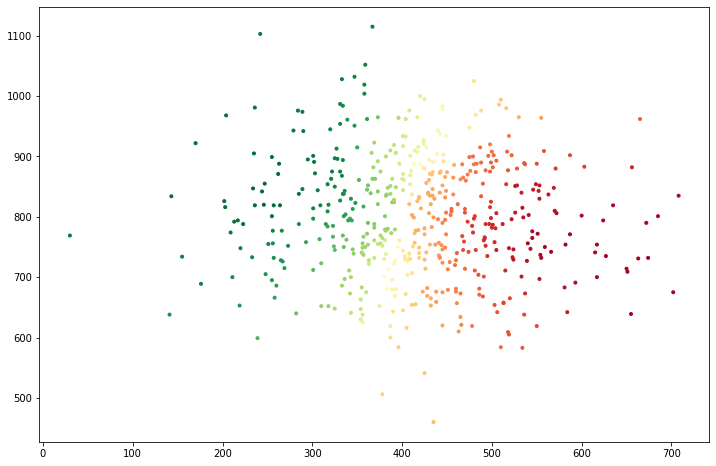

In [26]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
z = truth[:,2]
ax.scatter(truth[:,0], truth[:,1], marker='.', c=fiedler_vector,cmap='RdYlGn');


## Other Synchronization Problems

The "mountain shape" problems we discussed above are instances of a class of estimation problems called **synchronization problems**, in which we are given a set of *pairwise relative measurements*, and our goal is to estimate a set of absolute quantitities. 

Arguably the most studied synchronization problem in computer vision is *rotation averaging*, where we are given a set of relative rotations $R_{ij}$ between cameras and the goal is to estimate the absolute orientation $R_i$ for every camera. This is a crucial step in 3D reconstruction algorithms.

We have recently published a paper on [Shonan Rotation Averaging](https://dellaert.github.io/ShonanAveraging/), where the eigenvalue and eigenvectors of the graph Laplacian are used in both the analysis and convergence certificates.